In [1]:
!git clone https://github.com/lolpa1n/digital-peter-ocrv

Cloning into 'digital-peter-ocrv'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (25/25), done.


In [2]:
DATA_PATH = '../input/PETER/data_anon'
!ls '{DATA_PATH}'

images	mapper.csv  words


In [3]:
from glob import glob
import pandas as pd
from tqdm import tqdm
import cv2
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

# Rotate and Flip Vertical Images

In [4]:
import sys

sys.path.insert(0, 'digital-peter-ocrv')

from flip import Predictor as FlipPredictor, get_model as get_flip_model
from utils import load_image, resize_if_need, make_img_padding_around

IMAGE_H = 128
IMAGE_W = 1024

class FlipRetriever(Dataset):
    def __init__(self, ids, images):
        self.ids = ids
        self.images = images

    def __getitem__(self, idx):
        _id = self.ids[idx]
        image = self.images[idx].copy()
        image = resize_if_need(image, IMAGE_H, IMAGE_W)
        image = make_img_padding_around(image, IMAGE_H, IMAGE_W)
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image)
        image = image.permute(2, 0, 1)
        return {
            'id': _id,
            'image': image,
        }

    def __len__(self):
        return len(self.images)

In [5]:
os.makedirs('prepared_datasets', exist_ok=True)
!rm -rf 'prepared_datasets/peter'
os.makedirs('prepared_datasets/peter', exist_ok=True)
os.makedirs('prepared_datasets/peter/images', exist_ok=True)

In [6]:
flip_images = []
flip_ids = []
for path in tqdm(glob(f'{DATA_PATH}/images/*.jpg')):
    filename = path.split('/')[-1]
    image, rotated = load_image(path)
    h, w, c = image.shape
    skip_flip = 0.8333 < (h / w) < 1.2
    if not skip_flip and rotated:
        flip_images.append(image)
        flip_ids.append(filename)
    else:
        cv2.imwrite(f'prepared_datasets/peter/images/{filename}', image)

100%|██████████| 9694/9694 [01:16<00:00, 127.41it/s]


In [7]:
len(flip_images), len(flip_ids)

(121, 121)

In [8]:
flip_retriever = FlipRetriever(flip_ids, flip_images)
flip_loader = DataLoader(
    flip_retriever,
    batch_size=16,
    num_workers=1,
    sampler=SequentialSampler(flip_retriever),
    pin_memory=False,
)
flip_model = get_flip_model()
flip_predictor = FlipPredictor(model=flip_model, device=torch.device('cuda:0'))
flip_predictions = flip_predictor.run_inference(flip_loader)

for image, _id in zip(flip_images, flip_ids):
    flip_prediction = flip_predictions.get(_id)
    if flip_prediction is not None:
        if flip_prediction['pred_vert']:
            image = cv2.flip(image, 0)
        if flip_prediction['pred_hori']:
            image = cv2.flip(image, 1)
            
    cv2.imwrite(f'prepared_datasets/peter/images/{_id}', image)

In [9]:
len(glob('prepared_datasets/peter/images/*.jpg')), len(glob(f'{DATA_PATH}/images/*.jpg'))

(9694, 9694)

# Prepare Marking

In [10]:
mapper = pd.read_csv(f'{DATA_PATH}/mapper.csv', index_col=0)
mapper.shape[0], len(glob(f'{DATA_PATH}/images/*.jpg')), len(glob(f'{DATA_PATH}/words/*.txt'))

(9694, 9694, 9694)

In [11]:
marking = []
for _, row in tqdm(mapper.iterrows(), total=mapper.shape[0]):
    sample_id = row['new_name'][:-4]
    text = open(f'{DATA_PATH}/words/{sample_id}.txt').read().strip()
    if row['train']:
        stage = 'train'
    elif row['public']:
        stage = 'valid'
    elif row['private']:
        stage = 'test'
    else:
        if sample_id in [
            '27_46_30', '26_53_19', '25_3_2', '9_18_23', '25_11_23', '27_28_0', '5_54_23', # nan
            '9_18_20', '31_18_0', '27_56_31', '21_4_20', '39_9_2', '32_16_17', '20_1_28', # nan
            '27_36_0', '31_8_11', '20_1_12', '0_18_16', '28_12_19', '27_27_0', '25_22_0', # nan
            '27_9_25', '27_23_2', '25_19_0', '27_40_0', '5_93_4', '25_21_17', '26_3_55', # nan
            '27_38_0', '38_44_9', '39_3_21', '5_70_13', '38_48_6', '31_2_21', '42_9_18', # nan
            '29_3_0', '27_9_7', '27_46_29', # nan
        ]:
            stage = 'train'
        elif sample_id in ['24_38_7', '25_6_0', '24_37_1',]:
            stage = 'train'
        else:
            raise

    marking.append({
        'sample_id': sample_id,
        'path': f'peter/images/{sample_id}.jpg',
        'text': text,
        'stage': stage,
    })

marking = pd.DataFrame(marking).set_index('sample_id')

100%|██████████| 9694/9694 [00:00<00:00, 11766.20it/s]


In [12]:
marking.head()

,path,text,stage
sample_id,,,
15_8_11,peter/images/15_8_11.jpg,в тонигъ загналъ какъ росиские войски гдѣ я каман,test
32_2_1,peter/images/32_2_1.jpg,с воронежа пришел а другова зафтра,train
0_17_10,peter/images/0_17_10.jpg,человѣкъ тритца с собою на почте поѣ,train
21_10_5,peter/images/21_10_5.jpg,2,test
38_23_7,peter/images/38_23_7.jpg,том на мѣсецъ лтиллериским,train


In [13]:
marking['stage'].value_counts()

train    6237
test     1930
valid    1527
Name: stage, dtype: int64

sample_id: 38_2_3
text: трудитца по крайнѣй мѣрѣ i чтоб
image_shape: (504, 2367, 3)


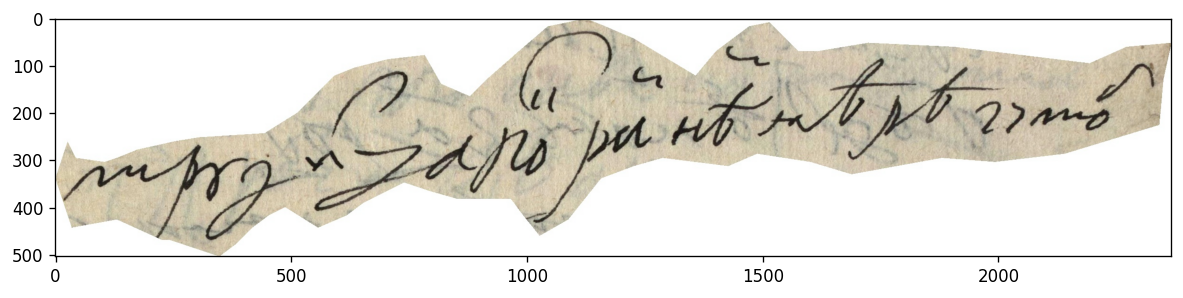

In [14]:
import matplotlib.pyplot as plt

idx = 777

sample = marking.iloc[idx]
text = sample['text']
image = cv2.imread(f'./prepared_datasets/{sample["path"]}')

print('sample_id:', sample.name)
print('text:', text)
print('image_shape:', image.shape)

plt.figure(num=None, figsize=(12, 3), dpi=120, facecolor='w', edgecolor='k')
plt.imshow(image);

In [15]:
marking.to_csv('./prepared_datasets/peter/marking.csv')

In [16]:
!cd ./prepared_datasets && ls peter

images	marking.csv


In [17]:
!cd ./prepared_datasets && tar -czvf peter.tar.gz peter > /dev/null

In [18]:
!du -sh ./prepared_datasets/peter.tar.gz

921M	./prepared_datasets/peter.tar.gz
